In [1]:
%matplotlib inline

from math import floor, ceil

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
torch.manual_seed(42)

dev = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)
batch_size = 32

# Download the dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_proportion = .8
# Use only a small part of dataset for faster results
train_set, val_set = torch.utils.data.random_split(dataset, [floor(train_proportion*len(dataset)), ceil(len(dataset)*(1 - train_proportion))])

loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


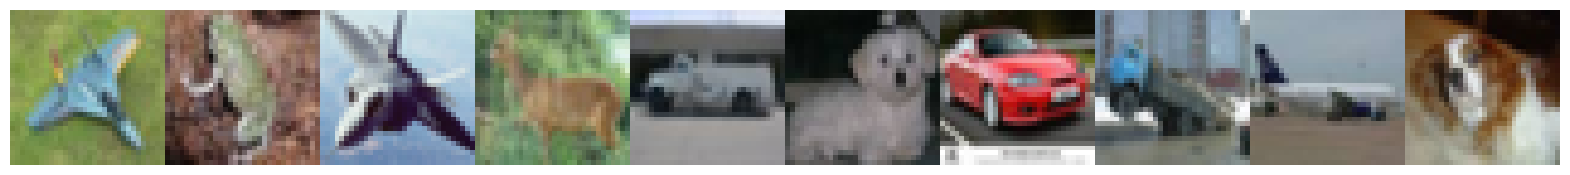

In [3]:
def concat_img(imgs):
    plt.figure(figsize=(20, 20))
    imgs = (imgs + 1) / 2
    imgs = imgs.movedim((0, 1, 2, 3), (0, 3, 1, 2)).detach().cpu().numpy() 
    axs = plt.imshow(np.concatenate(imgs.tolist(), axis=1))
    plt.axis('off')
    plt.show()
img, _ = next(iter(loader))
concat_img(img[:10])

In [4]:
class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(16, 16, 3),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(16, 16, 3),
            nn.LeakyReLU(inplace=True),
        )
        self.linear = nn.Sequential(
            nn.Linear(16*26*26, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, len(classes)),
            nn.Softmax(dim=1),
        )

        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        return self.linear(x)

In [5]:
model = BobNet()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
n_epochs = 20

losses = []
accs = []

for epoch in trange(n_epochs):
    for x, y in (t := tqdm(loader, leave=False)):
        pred = model(x)
        loss = loss_fn(pred, y)

        for p in model.parameters():
            p.grad = None
        loss.backward()
        optim.step()

        loss = loss.item()
        losses.append(loss)

        y_hat = pred.argmax(dim=1)
        acc = len(torch.nonzero(y_hat == y)) / len(y)
        accs.append(acc)

        t.set_description(f'loss={loss: .4f}, acc={acc: .4f}')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Final accuracy of 0.8125


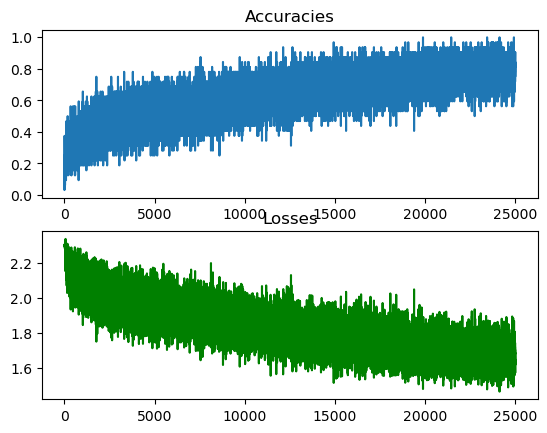

In [9]:
fig, axs = plt.subplots(2)
axs[0].plot(accs, label='Accuracies')
axs[0].set_title('Accuracies')
axs[1].plot(losses, 'g', label='Losses')
axs[1].set_title('Losses')
print(f'Final accuracy of {accs[-1]:.4f}')